<a href="https://colab.research.google.com/github/wayoo2019/Summer-Projects/blob/master/IEEE_3_EDA_FE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##3. EDA & Feature Engineering


*   Exploratory Data Analysis
*   Feature Engineering




In [ ]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#models
import xgboost as xgb
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

import time
import warnings
import gc


import datetime

pd.set_option('display.max_columns', None)
# plt.style.use(style = 'seaborn')

warnings.filterwarnings('ignore')

In [ ]:
# mount Google Drive to import data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


From part 2_RFE feature selection we have the top 30 features as below:

In [ ]:
fs_list = ['C1', 'card1', 'V315', 'D10', 'C6', 'V313', 'V127', 'C13', 'D15', 'C11', 'C14', 'V307', 'V310', 'V130', 'addr1', 'TransactionID', 'TransactionAmt', 'V308', 'C2', 'card2', 'V317', 'D1', 'C9', 'card5', 'V312', 'R_emaildomain','TransactionDT', 'V314']

In [ ]:
%%time
train = pd.read_parquet("drive/My Drive/ieee-fraud-detection/train.parquet.gzip")
test = pd.read_parquet("drive/My Drive/ieee-fraud-detection/test.parquet.gzip")

CPU times: user 9.68 s, sys: 1.85 s, total: 11.5 s
Wall time: 12.1 s


Convert deltaDT to DT

In [ ]:
startdate = datetime.datetime.strptime('2017-12-01', '%Y-%m-%d')
train['TransactionDT'] = train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
test['TransactionDT'] = test['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

In [ ]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,2017-12-02 00:00:00,68.5,W,13926,-999.0,150.0,discover,142.0,credit,315.0,87.0,19.0,-999.0,-999,-999,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,-999.0,13.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,13.0,13.0,-999.0,-999.0,-999.0,0.0,T,T,T,M2,F,T,-999,-999,-999,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.000000,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0

Define Plotting functions

####3.1.1 Covariate shift
Detect the features which do not have much distributuin difference between train and test data. Set train data == 0, and test data == 1, if the roc_auc (use LGBM algorithm) score is close to 0.5, which means the the distribution between two data set are same, and these features are more valuable for the prediction model

In [ ]:
# Define Covariate shift function for train and test verification
def covariate_shift(feature):
    df_card1_train = pd.DataFrame(data={feature: train[feature], 'isTest': 0})
    df_card1_test = pd.DataFrame(data={feature: test[feature], 'isTest': 1})

    # Creating a single dataframe
    df = pd.concat([df_card1_train, df_card1_test], ignore_index=True)
    
    # Encoding if feature is categorical
    if str(df[feature].dtype) in ['object', 'category']:
        df[feature] = LabelEncoder().fit_transform(df[feature].astype(str))
    
    # Splitting it to a training and testing set
    X_train, X_test, y_train, y_test = train_test_split(df[feature], df['isTest'], test_size=0.33, random_state=47, stratify=df['isTest'])

    clf = lgb.LGBMClassifier()
    clf.fit(X_train.values.reshape(-1, 1), y_train)
    roc_auc =  roc_auc_score(y_test, clf.predict_proba(X_test.values.reshape(-1, 1))[:, 1])

    del df, X_train, y_train, X_test, y_test
    gc.collect();
    
    return roc_auc

In [ ]:
def df_covariate_shift(col_list, df):
  temp = pd.DataFrame(columns = ['Features', 'roc_auc'])
  temp['Features'] = col_list
  temp['roc_auc'] = temp['Features'].map(covariate_shift)
  temp['inRange'] = (temp['roc_auc'].between(0.45, 0.55)).map({True:'Y', False:'N'}) 
  # suppose roc_roc is around 0.5 means there is no coveriate shift between train and test data
  return temp

In [ ]:
tab_covariate_shift = df_covariate_shift(fs_list, train)
tab_covariate_shift
#When AUC is 0.5, it means the model has no class separation capacity whatsoever.

,Features,roc_auc,inRange
0,C1,0.518535,Y
1,card1,0.540096,Y
2,V315,0.518228,Y
3,D10,0.629561,N
4,C6,0.514183,Y
5,V313,0.518375,Y
6,V127,0.516493,Y
7,C13,0.517899,Y
8,D15,0.657271,N
9,C11,0.522287,Y


In [ ]:
tab_covariate_shift[tab_covariate_shift['inRange'] == 'N']

,Features,roc_auc,inRange
3,D10,0.629561,N
8,D15,0.657271,N
12,V310,0.560773,N
13,V130,0.561665,N
15,TransactionID,0.999997,N
26,TransactionDT,0.999999,N


TransactionID, TransactionDT are different from time to time
D10, D15, V310, V130 have more difference between train and test data

In [ ]:
# check TransactionDT covariate shift based on hour, day, weekday
train["Hour"] = train["TransactionDT"].dt.hour
train["Day"] = train["TransactionDT"].dt.day
train["Weekday"] = train["TransactionDT"].dt.weekday

test["Hour"] = test["TransactionDT"].dt.hour
test["Day"] = test["TransactionDT"].dt.day
test["Weekday"] = test["TransactionDT"].dt.weekday


In [ ]:
covariate_shift('Hour')

0.5117794827929598

In [ ]:
covariate_shift('Day')

0.5255803988929467

In [ ]:
covariate_shift('Weekday')

0.5104857979720694

After converting TransactionDT to Hour, Day and Weekday, the score is close to 0.5

####3.1.2 TransactionDT

In [ ]:
train["Hour"] = train["TransactionDT"].dt.hour
train["Day"] = train["TransactionDT"].dt.day
train["Weekday"] = train["TransactionDT"].dt.weekday

test["Hour"] = test["TransactionDT"].dt.hour
test["Day"] = test["TransactionDT"].dt.day
test["Weekday"] = test["TransactionDT"].dt.weekday

In [ ]:
hour = train[["isFraud", "Hour"]].groupby(["Hour"]).isFraud.agg(["mean", "count"]).reset_index()
hour = hour.rename(columns={"mean": "hour_fraud_rate", "count": "hour_count"})

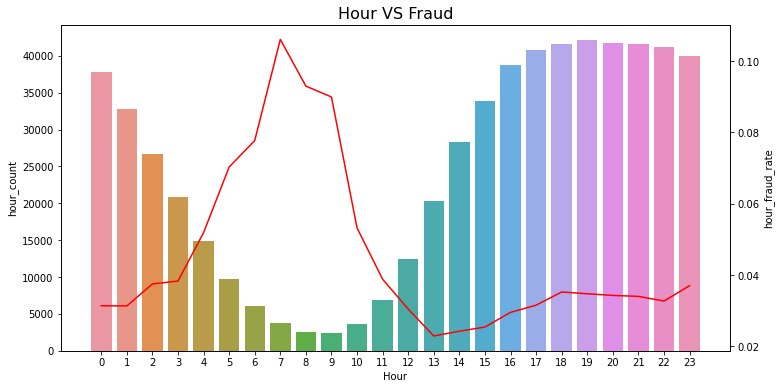

In [ ]:
# plot Hour VS Fraud
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_title("Hour VS Fraud", fontsize=16)
ax1.set_xlabel("Hour")
ax1.set_ylabel("hour_count")
ax1 = sns.barplot(x="Hour", y="hour_count", data=hour)
ax1.tick_params(axis="y")

ax2= ax1.twinx() # set up the 2nd axis

ax2.set_ylabel("hour_fraud_rate")
ax2 = sns.lineplot(x="Hour", y="hour_fraud_rate", data=hour, color="red")
ax2.tick_params(axis="y")
# ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right", fontsize=16)
plt.show()

It looks the highest fraud rate time is between 7:00 ~ 9:00 am;
However, there is no obvious pattern between fraud rate and day of month or day of week

In [ ]:
day = train[["isFraud", "Day"]].groupby(["Day"]).isFraud.agg(["mean", "count"]).reset_index()
day = day.rename(columns={"mean": "day_fraud_rate", "count": "day_count"})


In [ ]:
wkday = train[["isFraud", "Weekday"]].groupby(["Weekday"]).isFraud.agg(["mean", "count"]).reset_index()
wkday = wkday.rename(columns={"mean": "wkday_fraud_rate", "count": "wkday_count"})
wkday

,Weekday,wkday_fraud_rate,wkday_count
0,0,0.035644,70223
1,1,0.031452,85433
2,2,0.033048,84815
3,3,0.034514,85356
4,4,0.037174,86377
5,5,0.036040,98502
6,6,0.037115,79834


Feature engineering single feature 'TransactionDT' and veirfy its prediction power

In [ ]:
# Use "Hour" as only feature for predition
y = train['isFraud']
X = pd.DataFrame()
X['Hour'] = train['Hour']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=47, stratify=y)
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.5618803727883895


In [ ]:
del X, y, X_train, X_test, y_train, y_test

In [ ]:
# Use "Hour", "Day" for predition
y = train['isFraud']
X = pd.DataFrame()
X['Hour'] = train['Hour']
X['Day'] = train['Day']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=47, stratify=y)
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.5829280255946373


In [ ]:
del X, y, X_train, X_test, y_train, y_test

In [ ]:
# Use "Hour", "Day", " Weekday" for predition
y = train['isFraud']
X = pd.DataFrame()
X['Hour'] = train['Hour']
X['Day'] = train['Day']
X['Weekday'] = train['Weekday']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=47, stratify=y)
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.6162206569101601


In [ ]:
del X, y, X_train, X_test, y_train, y_test

In [ ]:
y = train['isFraud']
X = pd.DataFrame()

X['Hour'] = train['Hour']
X['Hour_count'] = train['Hour'].map(pd.concat([train['Hour'], test['Hour']], ignore_index=True).value_counts(dropna=False))

X['Day'] = train['Day']
X['Day_count'] = train['Day'].map(pd.concat([train['Day'], test['Day']], ignore_index=True).value_counts(dropna=False))

X['Weekday'] = train['Weekday']
X['Weekday_count'] = train['Weekday'].map(pd.concat([train['Weekday'], test['Weekday']], ignore_index=True).value_counts(dropna=False))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=47, stratify=y)

clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.6172428682162309


ROC AUC score increases from 0.56 to 0.616 when use feature "Hour" only ro "Hour", "Day", " Weekday". There is a slightly improvment after adds feature count number, the ROC AUC score increases to 0.617. We'll keep it mind but this time, we don't consider to add this kind of variales

####3.1.2 R_emaildomain & P_emaildomain

In [ ]:
train['P_Email'] = train['P_emaildomain'].str.split(".", expand=True)[0]
train['R_Email'] = train['R_emaildomain'].str.split(".", expand=True)[0]

test['P_Email'] = test['P_emaildomain'].str.split(".", expand=True)[0]
test['R_Email'] = test['R_emaildomain'].str.split(".", expand=True)[0]

In [ ]:
p_email = train[["isFraud", "P_Email"]].groupby(["P_Email"]).isFraud.agg(["mean", "count"]).reset_index()
p_email = p_email.rename(columns={"P_Email" : "Email", "mean": "P_Email_fraud_rate", "count": "P_Email_count"})
p_email.sort_values(by=["P_Email_fraud_rate", "P_Email_count"], ascending=False).head(10)

,Email,P_Email_fraud_rate,P_Email_count
29,protonmail,0.407895,76
22,mail,0.189624,559
0,aim,0.126984,315
27,outlook,0.097398,5534
17,hotmail,0.052516,46005
15,gmail,0.043496,228851
12,embarqmail,0.034615,260
20,live,0.032501,3846
21,mac,0.032110,436
18,icloud,0.031434,6267


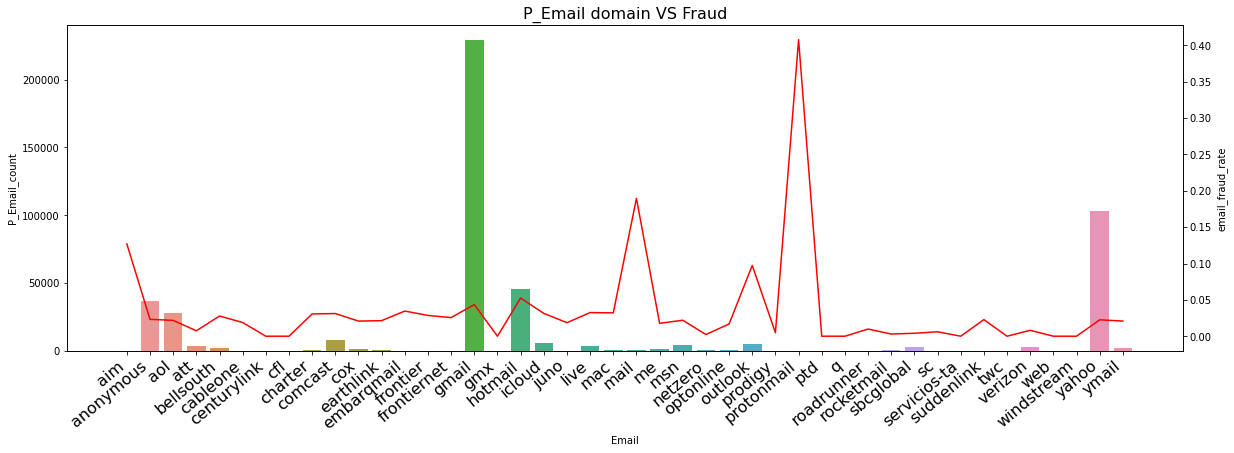

In [ ]:
# plot P_Email domain VS Fraud
fig, ax1 = plt.subplots(figsize=(20, 6))

ax1.set_title("P_Email domain VS Fraud", fontsize=16)
ax1.set_xlabel("P_Email")
ax1.set_ylabel("P_email_count")
ax1 = sns.barplot(x="Email", y="P_Email_count", data=p_email)
ax1.tick_params(axis="y")

ax2= ax1.twinx() # set up the 2nd axis

ax2.set_ylabel("email_fraud_rate")
ax2 = sns.lineplot(x="Email", y="P_Email_fraud_rate", data=p_email, color="red")
ax2.tick_params(axis="y")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right", fontsize=16)
plt.show()

In [ ]:
r_email = train[["isFraud", "R_Email"]].groupby(["R_Email"]).isFraud.agg(["mean", "count"]).reset_index()
r_email = r_email.rename(columns={"R_Email" : "Email", "mean": "R_Email_fraud_rate", "count": "R_Email_count"})
r_email.sort_values(by=["R_Email_fraud_rate", "R_Email_count"], ascending=False).head(10)

,Email,R_Email_fraud_rate,R_Email_count
29,protonmail,0.951220,41
22,mail,0.377049,122
27,outlook,0.160204,2940
18,icloud,0.128755,1398
15,gmail,0.118986,57242
25,netzero,0.086957,23
17,hotmail,0.076485,28241
11,earthlink,0.075949,79
20,live,0.052196,1571
43,yahoo,0.046235,13691


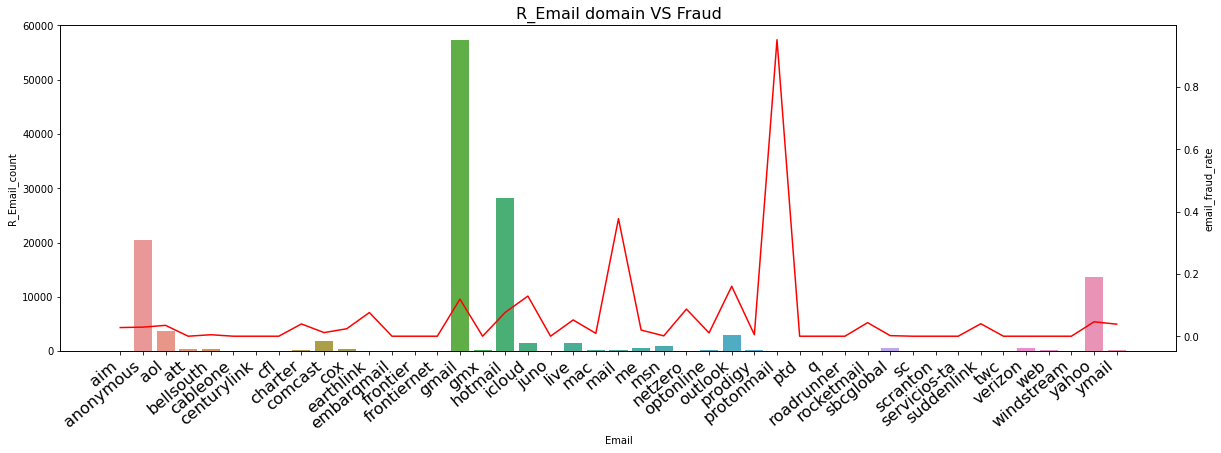

In [ ]:
# plot R_Email domain VS Fraud
fig, ax1 = plt.subplots(figsize=(20, 6))

ax1.set_title("R_Email domain VS Fraud", fontsize=16)
ax1.set_xlabel("R_Email")
ax1.set_ylabel("R_email_count")
ax1 = sns.barplot(x="Email", y="R_Email_count", data=r_email)
ax1.tick_params(axis="y")

ax2= ax1.twinx() # set up the 2nd axis

ax2.set_ylabel("email_fraud_rate")
ax2 = sns.lineplot(x="Email", y="R_Email_fraud_rate", data=r_email, color="red")
ax2.tick_params(axis="y")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right", fontsize=16)
plt.show()

In [ ]:
email = pd.merge(p_email, r_email, how="left", on="Email")
email.sort_values(by=["P_Email_fraud_rate", "R_Email_fraud_rate"], ascending=False).head(20)

,Email,P_Email_fraud_rate,P_Email_count,R_Email_fraud_rate,R_Email_count
29,protonmail,0.407895,76,0.951220,41
22,mail,0.189624,559,0.377049,122
0,aim,0.126984,315,0.027778,36
27,outlook,0.097398,5534,0.160204,2940
17,hotmail,0.052516,46005,0.076485,28241
15,gmail,0.043496,228851,0.118986,57242
12,embarqmail,0.034615,260,0.000000,68
20,live,0.032501,3846,0.052196,1571
21,mac,0.032110,436,0.009174,218
18,icloud,0.031434,6267,0.128755,1398


protonmail has the highest fraud rate both as P_email (purchaser) and R_Email (receiver).

In [ ]:
train['email_same'] = None
train['email_same'].loc[train.P_Email==train.R_Email] = 0
train['email_same'].loc[train.P_Email!=train.R_Email] = 1
train['email_same'].loc[train.P_Email.isnull() & train.R_Email.isnull()] = -1
train['email_same'] = train['email_same'].astype(int)
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,Hour,Day,Weekday,P_Email,R_Email,email_same
0,2987000,0,2017-12-02 00:00:00,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,None,None,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,None,None,None,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,0,2,5,None,None,-1
1,2987001,0,2017-12-02 00:00:

In [ ]:
y = train['isFraud']
X = pd.DataFrame()

X['P_Email'] = train['P_Email']
X['R_Email'] = train['R_Email']

le = LabelEncoder()
le.fit(list(X['P_Email'].astype(str).values))
X['P_Email'] = le.transform(list(X['P_Email'].astype(str).values))

le.fit(list(X['R_Email'].astype(str).values))
X['R_Email'] = le.transform(list(X['R_Email'].astype(str).values))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=47, stratify=y)
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.7069921708299608


In [ ]:
del X, y, X_train, X_test, y_train, y_test

Add P_Email & R_Email matching index as a feature for prediction:

In [ ]:
y = train['isFraud']
X = pd.DataFrame()

X['P_Email'] = train['P_Email']
X['R_Email'] = train['R_Email']
X['email_same'] = train['email_same'] # add P_Email & R_Email matching index as a variable 

le = LabelEncoder()
le.fit(list(X['P_Email'].astype(str).values))
X['P_Email'] = le.transform(list(X['P_Email'].astype(str).values))

le.fit(list(X['R_Email'].astype(str).values))
X['R_Email'] = le.transform(list(X['R_Email'].astype(str).values))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=47, stratify=y)
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.7074380086407073


In [ ]:
del X, y, X_train, X_test, y_train, y_test

It looks that emal_same does not improve prediction accuracy much, so delete it

In [ ]:
train = train.drop(columns='email_same', axis=1)
train.head(3)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,Hour,Day,Weekday,P_Email,R_Email
0,2987000,0,2017-12-02 00:00:00,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,None,None,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,None,None,None,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,0,2,5,None,None
1,2987001,0,2017-12-02 00:00:01,29.0,W,2755

#### 3.1.3 TransactionAmt

In [ ]:
train['TransactionAmt_decimal'] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)
test['TransactionAmt_decimal'] = ((test['TransactionAmt'] - test['TransactionAmt'].astype(int)) * 1000).astype(int)

train['TransactionAmt_decimal_lenght'] = train['TransactionAmt'].astype(str).str.split('.', expand=True)[1].str.len()
test['TransactionAmt_decimal_lenght'] = test['TransactionAmt'].astype(str).str.split('.', expand=True)[1].str.len()

In [ ]:
train[['TransactionAmt_decimal', 'isFraud']].groupby(['TransactionAmt_decimal']).isFraud.agg(["mean", "count"]).reset_index()

,TransactionAmt_decimal,mean,count
0,0,0.032919,356087
1,3,0.000000,8
2,7,0.032258,62
3,11,0.666667,3
4,13,0.000000,9
...,...,...,...
330,984,0.032710,856
331,988,0.000000,40
332,992,0.028424,387
333,994,0.000000,2


In [ ]:
def plot_density(feature):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
  sns.kdeplot(train[feature], ax=axes[0], label='Train');
  sns.kdeplot(test[feature], ax=axes[0], label='Test');

  sns.kdeplot(train[train['isFraud']==0][feature], ax=axes[1], label='isFraud 0')
  sns.kdeplot(train[train['isFraud']==1][feature], ax=axes[1], label='isFraud 1')

  fig.suptitle(feature, fontsize=18);
  axes[0].set_title('Train/Test KDE distribution');
  axes[1].set_title('Target value KDE distribution');
  axes[0].legend()
  axes[1].legend()


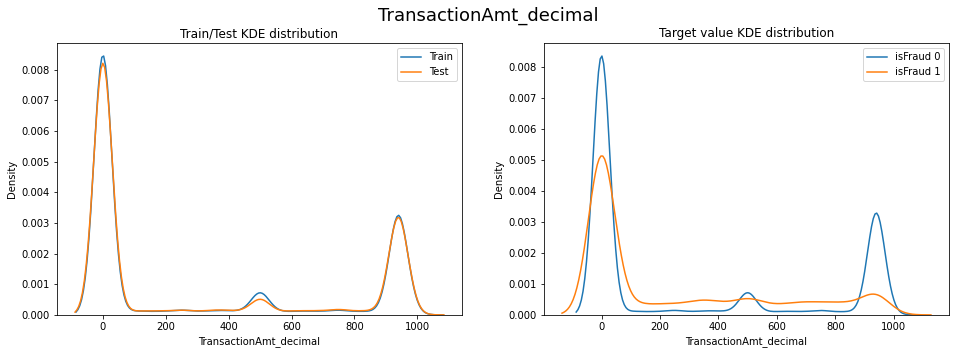

In [ ]:
plot_density('TransactionAmt_decimal')

The kdeplot shows train and test have same distribution. In train's data, fraud has high density around 0 and 0.1 transactionAmt decimal 

There is a relationship between transaction day and transactionAMT_decimal

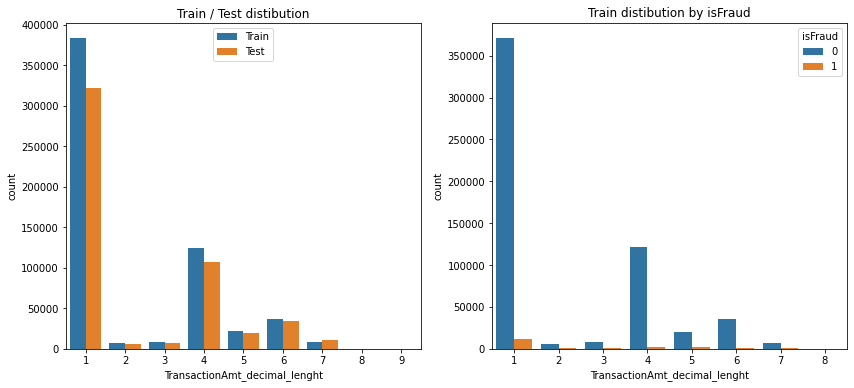

In [ ]:
df_train = pd.DataFrame(data={'TransactionAmt_decimal_lenght': train['TransactionAmt_decimal_lenght'], 'isTest': 0})
df_test = pd.DataFrame(data={'TransactionAmt_decimal_lenght': test['TransactionAmt_decimal_lenght'], 'isTest': 1})
df = pd.concat([df_train, df_test], ignore_index=True)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.countplot(data=df.fillna('NaN'), x='TransactionAmt_decimal_lenght', hue='isTest', ax=axes[0]);
sns.countplot(data=train[['TransactionAmt_decimal_lenght', 'isFraud']].fillna('NaN'), x='TransactionAmt_decimal_lenght', hue='isFraud', ax=axes[1]);
axes[0].set_title('Train / Test distibution');
axes[1].set_title('Train distibution by isFraud');
axes[0].legend(['Train', 'Test']);

Train and test have same decimal length distribution. Also, train has highest fraud at decimal length = 1

In [ ]:
y = train['isFraud']
X = pd.DataFrame()

X['TransactionAmt'] = train['TransactionAmt']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=47, stratify=y)
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.7071004615679237


In [ ]:
del X, y, X_train, X_test, y_train, y_test

In [ ]:
y = train['isFraud']
X = pd.DataFrame()

X['TransactionAmt'] = train['TransactionAmt']
X['TransactionAmt_decimal'] = train['TransactionAmt_decimal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=47, stratify=y)
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.7535579176562126


In [ ]:
del X, y, X_train, X_test, y_train, y_test

In [ ]:
y = train['isFraud']
X = pd.DataFrame()

X['TransactionAmt'] = train['TransactionAmt']
X['TransactionAmt_decimal'] = train['TransactionAmt_decimal']
X['TransactionAmt_decimal_lenght'] = train['TransactionAmt_decimal_lenght']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=47, stratify=y)
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.7537053270293729


In [ ]:
del X, y, X_train, X_test, y_train, y_test

Feature engineering with single original feature 'TransactionAmt', the ROC AUC score increases from 0.7 to 0.75. TransactionAmt_decimal_lenght does not improve too much for the score, so delete it

In [ ]:
train = train.drop(columns='TransactionAmt_decimal_lenght', axis=1)
test = test.drop(columns='TransactionAmt_decimal_lenght', axis=1)

#### 3.1.4 Card4

In [ ]:
card4 = train[["isFraud", "card4"]].groupby(["card4"]).isFraud.agg(["mean", "count"]).reset_index()
card4 = card4.rename(columns={"mean": "card4_fraud_rate", "count": "card4_count"})
card4.sort_values(by=["card4_fraud_rate", "card4_count"], ascending=False).head(10)

,card4,card4_fraud_rate,card4_count
1,discover,0.077282,6651
3,visa,0.034756,384767
2,mastercard,0.034331,189217
0,american express,0.028698,8328


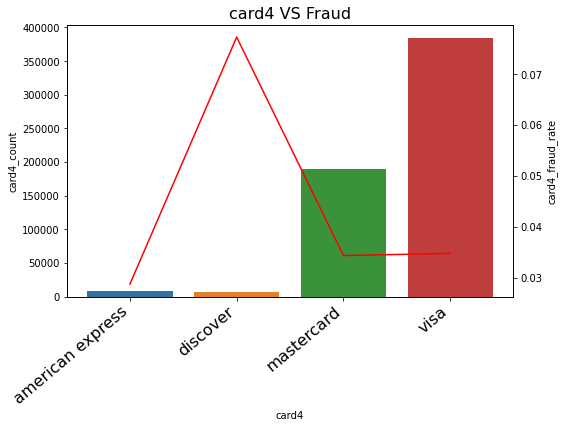

In [ ]:
# plot P_Email domain VS Fraud
fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.set_title("card4 VS Fraud", fontsize=16)
ax1.set_xlabel("card4")
ax1.set_ylabel("card4_count")
ax1 = sns.barplot(x="card4", y="card4_count", data=card4)
ax1.tick_params(axis="y")

ax2= ax1.twinx() # set up the 2nd axis

ax2.set_ylabel("card4_fraud_rate")
ax2 = sns.lineplot(x="card4", y="card4_fraud_rate", data=card4, color="red")
ax2.tick_params(axis="y")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right", fontsize=16)
plt.show()

In [ ]:
y = train['isFraud']
X = pd.DataFrame()

X['card4'] = train['card4']

le = LabelEncoder()
le.fit(list(X['card4'].astype(str).values))
X['card4'] = le.transform(list(X['card4'].astype(str).values))

le.fit(list(X['card4'].astype(str).values))
X['card4'] = le.transform(list(X['card4'].astype(str).values))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=47, stratify=y)
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.5110962478752612


In [ ]:
del X, y, X_train, X_test, y_train, y_test

In [ ]:
y = train['isFraud']
X = pd.DataFrame()

X['card4'] = train['card4']
X['card4_count'] = train['card4'].map(pd.concat([train['card4'], test['card4']], ignore_index=True).value_counts(dropna=False))

le = LabelEncoder()
le.fit(list(X['card4'].astype(str).values))
X['card4'] = le.transform(list(X['card4'].astype(str).values))

le.fit(list(X['card4'].astype(str).values))
X['card4'] = le.transform(list(X['card4'].astype(str).values))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=47, stratify=y)
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.5110962478752612


Card4 does not improve very much about the score

In [ ]:
del X, y, X_train, X_test, y_train, y_test

####3.1.5 Card6

In [ ]:
card6 = train[["isFraud", "card6"]].groupby(["card6"]).isFraud.agg(["mean", "count"]).reset_index()
card6 = card6.rename(columns={"mean": "card6_fraud_rate", "count": "card6_count"})
card6.sort_values(by=["card6_fraud_rate", "card6_count"], ascending=False).head(10)

,card6,card6_fraud_rate,card6_count
1,credit,0.066785,148986
2,debit,0.024263,439938
3,debit or credit,0.000000,30
0,charge card,0.000000,15


In [ ]:
y = train['isFraud']
X = pd.DataFrame()

X['card6'] = train['card6']

le = LabelEncoder()
le.fit(list(X['card6'].astype(str).values))
X['card6'] = le.transform(list(X['card6'].astype(str).values))

le.fit(list(X['card6'].astype(str).values))
X['card6'] = le.transform(list(X['card6'].astype(str).values))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=47, stratify=y)
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.619133309696055


In [ ]:
y = train['isFraud']
X = pd.DataFrame()

X['card6'] = train['card6']
X['card6_count'] = train['card6'].map(pd.concat([train['card6'], test['card6']], ignore_index=True).value_counts(dropna=False))

le = LabelEncoder()
le.fit(list(X['card6'].astype(str).values))
X['card6'] = le.transform(list(X['card6'].astype(str).values))

le.fit(list(X['card6'].astype(str).values))
X['card6'] = le.transform(list(X['card6'].astype(str).values))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=47, stratify=y)
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.6191485138341944


Card6_count does not improve very much about the score, so delete it. but card6 is not in the top30 feature list

####3.1.6 Ceate a column to count missing value of each row

In [ ]:
train['mis_count'] = train.isnull().sum(axis=1)
test['mis_count'] = test.isnull().sum(axis=1)

In [ ]:
train = train.fillna(-999)
test = test.fillna(-999)

In [ ]:
train[fs_list].select_dtypes('object').columns.tolist()

['R_emaildomain', 'P_Email', 'R_Email']

In [ ]:
train['TransactionDT'].dtype

dtype('<M8[ns]')

####3.1.7 Card1

In [ ]:
y = train['isFraud']
X = pd.DataFrame()

X['card1'] = train['card1']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47, stratify=y)
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.6931766027770399


In [ ]:
del X, y, X_train, X_test, y_train, y_test

In [ ]:
y = train['isFraud']
X = pd.DataFrame()

X['card1'] = train['card1']
X['card1_count'] = train['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47, stratify=y)
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.7696097106702444


card1_count significantly increases the prediction score, so definitely keep it

####3.1.8 find client by D1 and card

In [ ]:
train['D1'].isnull().sum()

1269

In [ ]:
train['diff_days_from_first_transaction'] = train['D1'].fillna(0).apply(lambda x: (datetime.timedelta(days = x)))
train['client_firstdate'] = (train['TransactionDT'] - train['diff_days_from_first_transaction']).apply(lambda x:str(x.date()))
train.head(3)

test['diff_days_from_first_transaction'] = test['D1'].fillna(0).apply(lambda x: (datetime.timedelta(days = x)))
test['client_firstdate'] = (test['TransactionDT'] - test['diff_days_from_first_transaction']).apply(lambda x:str(x.date()))

In [ ]:
train[['TransactionDT', 'D1', 'diff_days_from_first_transaction', 'client_firstdate']].head()

,TransactionDT,D1,diff_days_from_first_transaction,client_firstdate
0,2017-12-02 00:00:00,14.0,14 days,2017-11-18
1,2017-12-02 00:00:01,0.0,0 days,2017-12-02
2,2017-12-02 00:01:09,0.0,0 days,2017-12-02
3,2017-12-02 00:01:39,112.0,112 days,2017-08-12
4,2017-12-02 00:01:46,0.0,0 days,2017-12-02


In [ ]:
train = train.drop(columns='diff_days_from_first_transaction')
test = test.drop(columns='diff_days_from_first_transaction')

In [ ]:
del X, y, X_train, X_test, y_train, y_test

In [ ]:
y = train['isFraud']
X = pd.DataFrame()

X['client_firstdate'] = train['client_firstdate']


le = LabelEncoder()
le.fit(list(X['client_firstdate'].astype(str).values))
X['client_firstdate'] = le.transform(list(X['client_firstdate'].astype(str).values))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=47, stratify=y)
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.6630882024668578


In [ ]:
y = train['isFraud']
X = pd.DataFrame()

X['client_firstdate'] = train['client_firstdate']
X['client_firstdate_count'] = train['client_firstdate'].map(pd.concat([train['client_firstdate'], test['client_firstdate']], ignore_index=True).value_counts(dropna=False))

le = LabelEncoder()
le.fit(list(X['client_firstdate'].astype(str).values))
X['client_firstdate'] = le.transform(list(X['client_firstdate'].astype(str).values))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=47, stratify=y)
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.6852557364497733


In [ ]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')

In [ ]:
encode_FE(train, test,['addr1','card1','card2','card3','P_Email', 'R_Email'])

addr1_FE , card1_FE , card2_FE , card3_FE , P_Email_FE , R_Email_FE , 

In [ ]:
def roc_test(feature):
  y = train['isFraud']
  X = pd.DataFrame()

  X[feature] = train[feature]


  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=47, stratify=y)
  clf = lgb.LGBMClassifier()
  clf.fit(X_train, y_train)
  print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
  del X, y, X_train, X_test, y_train, y_test

In [ ]:
roc_test('addr1_FE')

ROC AUC score: 0.6856649915328605


In [ ]:
roc_test('card1_FE')

ROC AUC score: 0.7014139622327883


In [ ]:
roc_test('card2_FE')

ROC AUC score: 0.7314306072841963


In [ ]:
roc_test('card3_FE')

ROC AUC score: 0.6408076470931257


In [ ]:
roc_test('P_Email_FE')

ROC AUC score: 0.6000439128417


In [ ]:
roc_test('R_Email_FE')

ROC AUC score: 0.6817284208499823


In [ ]:
# LABEL ENCODE
def encode_LE(col,train=train,test=test,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000: 
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')

In [ ]:
# COMBINE FEATURES
def encode_CB(col1,col2,df1=train,df2=test):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')

In [ ]:
# COMBINE COLUMNS CARD1+ADDR1, CARD1+ADDR1+P_EMAILDOMAIN
encode_CB('card1','addr1')
encode_CB('card1_addr1','P_Email')

card1_addr1 , card1_addr1_P_Email , 

In [ ]:
# FREQUENCY ENOCDE
encode_FE(train, test,['card1_addr1','card1_addr1_P_Email'])

card1_addr1_FE , card1_addr1_P_Email_FE , 

#### 3.1.9 Impute Missing Value

In [ ]:
train.head(1)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,Hour,Day,Weekday,P_Email,R_Email,TransactionAmt_decimal,TransactionAmt_decimal_lenght,mis_count,client_firstdate,addr1_FE,card1_FE,card2_FE,card3_FE,P_Email_FE,R_Email_FE,card1_addr1,card1_addr1_P_Email,card1_addr1_FE,card1_addr1_P_Email_FE
0,2987000,0,2017-12-02,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,None,None,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,None,None,None,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [ ]:
fs_30 = ['C1', 'card1', 'V315', 'D10', 'C6', 'V313', 'V127', 'C13', 'D15', 'C11', 'C14', 'V307', 'V310', 'V130', 'addr1', 'TransactionID', 'TransactionAmt', 'V308', 'C2', 'card2', 'V317', 'D1', 'C9', 'card5', 'V312', 'R_emaildomain','TransactionDT', 'V314']
fs_30.remove('TransactionDT')
fs_30.remove('TransactionID')
fs_30.extend(['TransactionAmt_decimal', 'P_Email', 'R_Email', 'Hour', 'Day', 'Weekday', 'mis_count','card1_addr1', 'card1_addr1_P_Email','card1_addr1_FE' , 'card1_addr1_P_Email_FE', 'addr1_FE' , 'card1_FE' , 'card2_FE' , 'card3_FE' , 'P_Email_FE' , 'R_Email_FE'])
fs_30.append('mis_count')
print(fs_30)

['C1', 'card1', 'V315', 'D10', 'C6', 'V313', 'V127', 'C13', 'D15', 'C11', 'C14', 'V307', 'V310', 'V130', 'addr1', 'TransactionAmt', 'V308', 'C2', 'card2', 'V317', 'D1', 'C9', 'card5', 'V312', 'R_emaildomain', 'V314', 'TransactionAmt_decimal', 'P_Email', 'R_Email', 'Hour', 'Day', 'Weekday', 'mis_count', 'card1_addr1', 'card1_addr1_P_Email', 'card1_addr1_FE', 'card1_addr1_P_Email_FE', 'addr1_FE', 'card1_FE', 'card2_FE', 'card3_FE', 'P_Email_FE', 'R_Email_FE', 'mis_count']


In [ ]:
len(fs_30)

44

In [ ]:
for col in train[fs_30]:
  if train[col].dtype == 'object':
    le = LabelEncoder()
    le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
    train[col] = le.transform(list(train[col].astype(str).values))
    test[col] = le.transform(list(test[col].astype(str).values))

In [ ]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }

In [ ]:
X = train[fs_30]
y = train['isFraud']
clf = lgb.LGBMClassifier()

cross_val_score(clf, X, y, cv=5, scoring='roc_auc').mean()

0.8948824962653348

In [ ]:
X = train[fs_30]
y = train['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47, stratify=y)
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.9237039264998351


In [ ]:
rfe_importance = pd.read_csv('/content/drive/MyDrive/ieee-fraud-detection/rfe_importance.csv')

In [ ]:
fs_98 = rfe_importance[rfe_importance['Score']>100]['Features'].tolist()
fs_98.remove('TransactionDT')
fs_98.remove('TransactionID')
fs_98.extend(['TransactionAmt_decimal', 'P_Email', 'R_Email', 'Hour', 'Day', 'Weekday', 'mis_count','card1_addr1', 'card1_addr1_P_Email','card1_addr1_FE' , 'card1_addr1_P_Email_FE','addr1_FE' , 'card1_FE' , 'card2_FE' , 'card3_FE' , 'P_Email_FE' , 'R_Email_FE'])
# fs_98.append('mis_count')
print(fs_98)

['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'dist1', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D15', 'M2', 'M3', 'M4', 'M5', 'M6', 'M9', 'V5', 'V12', 'V13', 'V20', 'V35', 'V36', 'V38', 'V45', 'V53', 'V54', 'V56', 'V61', 'V62', 'V75', 'V76', 'V78', 'V82', 'V83', 'V87', 'V96', 'V99', 'V126', 'V127', 'V128', 'V130', 'V131', 'V280', 'V282', 'V283', 'V285', 'V291', 'V294', 'V306', 'V307', 'V308', 'V310', 'V312', 'V313', 'V314', 'V315', 'V317', 'id_01', 'id_02', 'id_05', 'id_06', 'id_13', 'id_14', 'id_17', 'id_19', 'id_20', 'id_30', 'id_31', 'id_33', 'DeviceType', 'DeviceInfo', 'TransactionAmt_decimal', 'P_Email', 'R_Email', 'Hour', 'Day', 'Weekday', 'mis_count', 'card1_addr1', 'card1_addr1_P_Email', 'card1_addr1_FE', 'card1_addr1_P_Email_FE', 'addr1_FE', 'card1_FE', 'card2_FE', 'card3_FE', 'P_Email_FE', 'R_Emai

In [ ]:
len(fs_98)

113

In [ ]:
for col in train[fs_98]:
  if train[col].dtype == 'object':
    le = LabelEncoder()
    le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
    train[col] = le.transform(list(train[col].astype(str).values))
    test[col] = le.transform(list(test[col].astype(str).values))

In [ ]:
X = train[fs_98]
y = train['isFraud']
clf = lgb.LGBMClassifier()

cross_val_score(clf, X, y, cv=5, scoring='roc_auc').mean()

0.904792173789766

In [ ]:
X = train[fs_98]

y = train['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47, stratify=y)
clf = lgb.LGBMClassifier(
          max_bin = 63,
          num_leaves = 255,
          num_iterations = 500,
          learning_rate = 0.01,
          tree_learner = 'serial',
          is_dfing_metric = False,
          min_data_in_leaf = 1,
          min_sum_hessian_in_leaf = 100,
          sparse_threshold=1.0,
          # device = 'gpu',
          num_thread = -1,
          save_binary= True,
          seed= 42,
          feature_fraction_seed = 42,
          bagging_seed = 42,
          drop_seed = 42,
          data_random_seed = 42,
          objective = 'binary',
          boosting_type = 'gbdt',
          verbose = 1,
          metric = 'auc',
          is_unbalance = True,
          boost_from_average = False,
)
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.9539286117909851


In [ ]:
del X, y, X_train, X_test, y_train, y_test, clf

In [ ]:
X = train[fs_98]
y = train['isFraud']
clf = lgb.LGBMClassifier(
          max_bin = 63,
          num_leaves = 255,
          num_iterations = 500,
          learning_rate = 0.01,
          tree_learner = 'serial',
          is_dfing_metric = False,
          min_data_in_leaf = 1,
          min_sum_hessian_in_leaf = 100,
          sparse_threshold=1.0,
          # device = 'gpu',
          num_thread = -1,
          save_binary= True,
          seed= 42,
          feature_fraction_seed = 42,
          bagging_seed = 42,
          drop_seed = 42,
          data_random_seed = 42,
          objective = 'binary',
          boosting_type = 'gbdt',
          verbose = 1,
          metric = 'auc',
          is_unbalance = True,
          boost_from_average = False,
)
clf.fit(X, y)

LGBMClassifier(bagging_seed=42, boost_from_average=False, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, data_random_seed=42,
               drop_seed=42, feature_fraction_seed=42, importance_type='split',
               is_dfing_metric=False, is_unbalance=True, learning_rate=0.01,
               max_bin=63, max_depth=-1, metric='auc', min_child_samples=20,
               min_child_weight=0.001, min_data_in_leaf=1, min_split_gain=0.0,
               min_sum_hessian_in_leaf=100, n_estimators=100, n_jobs=-1,
               num_iterations=500, num_leaves=255, num_thread=-1,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, save_binary=True, ...)

In [ ]:
sub = pd.DataFrame()
sub['TransactionID'] = test['TransactionID']
sub['isFraud'] = clf.predict_proba(test[fs_98])[:, 1] 

In [ ]:
sub.to_csv('sub_113.csv', index=False)
!cp sub_113.csv "/content/drive/MyDrive/ieee-fraud-detection"

In [ ]:
X = train[fs_98]
y = train['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47, stratify=y)
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.8899507667032727
